In [2]:
from analysis_plot import *
plt.style.use(['science','no-latex','nature'])


# compute the roc per group


In [80]:

time_step = 199
task = 'income'
hidden_shape_dict = {
        'income':32, 
        'health':64, 
        'employment':64}

res_dict = {}


for client_idx in range(51):
    res_dict[client_idx] = {}
    res_dict[client_idx]['overall_0'] = {}
    res_dict[client_idx]['overall_0']['centra'] = []
    res_dict[client_idx]['overall_0']['fedavg'] = []
    res_dict[client_idx]['overall_0']['standalone'] = []

    res_dict[client_idx]['overall_1'] = {}
    res_dict[client_idx]['overall_1']['centra'] = []
    res_dict[client_idx]['overall_1']['fedavg'] = []
    res_dict[client_idx]['overall_1']['standalone'] = []

    for attr_idx in [1,2]: # s_value
        res_dict[client_idx]['{}_1'.format(attr_idx)] = {}

        res_dict[client_idx]['{}_1'.format(attr_idx)]['centra'] = []
        res_dict[client_idx]['{}_1'.format(attr_idx)]['fedavg'] = []
        res_dict[client_idx]['{}_1'.format(attr_idx)]['standalone'] = []
        res_dict[client_idx]['{}_0'.format(attr_idx)] = {}

        res_dict[client_idx]['{}_0'.format(attr_idx)]['centra'] = []
        res_dict[client_idx]['{}_0'.format(attr_idx)]['fedavg'] = []
        res_dict[client_idx]['{}_0'.format(attr_idx)]['standalone'] = []

for random_seed in [0,1,2,3,4]:
    folder_path = "../results/{}/run_{}".format(task,random_seed)
    data_file = "{}/data.pkl".format(folder_path)
    with open(data_file,'rb') as f:  # Python 3: open(..., 'rb')
        dataset = pickle.load(f)
    (num_user, users, train_data_num, test_data_num, train_data_global, test_data_global, val_data_global, \
                        train_data_local_num_dict, test_data_local_num_dict, train_data_local_dict, test_data_local_dict, val_data_local_dict, class_num, unselected_data_local_dict) = dataset 

    fedavg_model = TwoNN(census_input_shape_dict[task],hidden_shape_dict[task],2)
    fedavg_model.load_state_dict(torch.load("{}/fedavg_at_{}.pt".format(folder_path,time_step)))
    fedavg_model.eval()

    centra_model = TwoNN(census_input_shape_dict[task],hidden_shape_dict[task],2)
    centra_model.load_state_dict(torch.load("{}/centralized_at_{}.pt".format(folder_path,time_step)))
    centra_model.eval()
    
    with open("{}/standalone_at_{}.pt".format(folder_path,time_step),'rb') as f:
        standalone_models = pickle.load(f)
                    
    for client_idx in range(51):
        s_model = TwoNN(census_input_shape_dict[task],hidden_shape_dict[task],2)
        s_model.load_state_dict(standalone_models[client_idx])
        s_model.eval()
        
        x,y,s = get_dataset(test_data_local_dict[client_idx])
        converted_s = s[:,1] #gender
        
    
        centra_proba,_, _ = get_prediction(centra_model,x,y)
        fedavg_proba,_,_ = get_prediction(fedavg_model,x,y)
        standalone_proba,_,_  = get_prediction(s_model,x,y)   
        
       

        for label in [0,1]:
            index = (y==label)

            res_dict[client_idx][f'overall_{label}']['centra'].append(centra_proba[index,1])                                                          
            res_dict[client_idx][f'overall_{label}']['fedavg'].append(fedavg_proba[index,1])
            res_dict[client_idx][f'overall_{label}']['standalone'].append(standalone_proba[index,1])
            
            for s_value in np.unique(converted_s):            
                index = np.logical_and(converted_s==s_value,y==label)
                res_dict[client_idx]['{}_{}'.format(s_value,label)]['centra'].append(centra_proba[index,1])                                                          
                res_dict[client_idx]['{}_{}'.format(s_value,label)]['fedavg'].append(fedavg_proba[index,1])
                res_dict[client_idx]['{}_{}'.format(s_value,label)]['standalone'].append(standalone_proba[index,1])
                                                            
                    
            
            

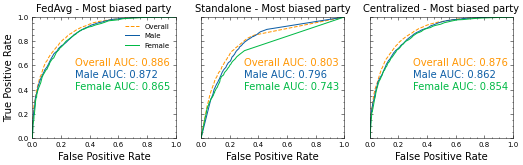

In [89]:
# compute the tpr rate and fpr
from sklearn import metrics

figs,axes = plt.subplots(1,3,sharex=True,sharey=True, figsize=(7.5,2.5))
client = 43
client_name = {
    43: 'Most biased party',
    50: 'Least biased party'
}
Model_type = ['FedAvg','Standalone','Centralized']
for idx,model_type in enumerate(['fedavg','standalone','centra']):
    auc = []
    tpr_list = []
    fpr_list = []
    for threshold in np.linspace(0,1,100):
        tpr_list.append(np.mean(np.concatenate(res_dict[client]['overall_1'][model_type]) > threshold))
        fpr_list.append(np.mean(np.concatenate(res_dict[client]['overall_0'][model_type]) > threshold))

    axes[idx].plot(fpr_list,tpr_list,label='Overall',ls='--',color='C2')
    auc.append(metrics.auc(fpr_list, tpr_list))
    random_pred = np.zeros(np.concatenate(res_dict[client]['overall_0'][model_type]).shape[0])
    fpr_list.append(np.mean(random_pred > threshold))
    fpr_list.append(np.mean(np.concatenate(res_dict[client]['overall_0'][model_type]) > threshold))
    


    
    for group in [1,2]:
        tpr_list = []
        fpr_list = []
        for threshold in np.linspace(0,1,100):
            tpr_list.append(np.mean(np.concatenate(res_dict[client][f'{group}_1'][model_type]) > threshold))
            fpr_list.append(np.mean(np.concatenate(res_dict[client][f'{group}_0'][model_type]) > threshold))

        axes[idx].plot(fpr_list,tpr_list,label=['Male','Female'][group-1])
    
        auc.append(metrics.auc(fpr_list, tpr_list))
    
    axes[idx].text(0.3,0.6,'Overall AUC: {}'.format(round(auc[0],3)),color='C2')
    axes[idx].text(0.3,0.5,'Male AUC: {}'.format(round(auc[1],3)),color='C0')
    axes[idx].text(0.3,0.4,'Female AUC: {}'.format(round(auc[2],3)),color='C1')

    font_size=10
    axes[idx].set_title(f'{Model_type[idx]} - {client_name[client]}', fontsize=10)
    axes[0].set_ylabel('True Positive Rate',fontsize=font_size)
    axes[idx].set_xlabel('False Positive Rate',fontsize=font_size)
    axes[0].set_ylim(0,1)
    axes[0].set_xlim(0,1)
    
axes[0].legend()
plt.tight_layout()
pathlib.Path('{}/roc/'.format(task)).mkdir(parents=True, exist_ok=True) 
plt.savefig('{}/roc/roc_attr_{}_{}.png'.format(task,1,client),dpi=300)

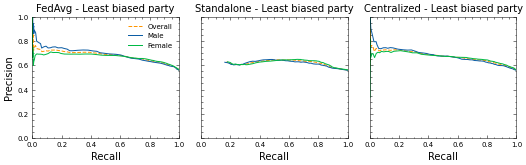

In [14]:
# compute the tpr rate and fpr

figs,axes = plt.subplots(1,3,sharex=True,sharey=True, figsize=(7.5,2.5))
attr_idx = 0
Model_type = ['FedAvg','Standalone','Centralized']
for idx,model_type in enumerate(['fedavg','standalone','centra']):

    tpr_list = []
    fpr_list = []
    for threshold in np.linspace(0,1,100):
        tp = np.sum(np.concatenate(res_dict[client]['overall_1'][model_type]) > threshold).astype(float)
        fp = np.sum(np.concatenate(res_dict[client]['overall_0'][model_type]) > threshold).astype(float)
        fn = np.sum(np.concatenate(res_dict[client]['overall_1'][model_type]) <= threshold).astype(float)
        
        
       
        if tp+fp>0:
            precision = tp/(tp+fp) 
            recall = tp/(tp+fn)
            tpr_list.append(precision)
            fpr_list.append(recall)
                

    axes[idx].plot(fpr_list,tpr_list,label='Overall',ls='--',color='C2')


        
    for group in [1,2,3,6]: # race
        tpr_list = []
        fpr_list = []
        for threshold in np.linspace(0,1,100):
            tp = np.sum(np.concatenate(res_dict[client][f'{group}_1'][model_type]) > threshold).astype(float)
            fp = np.sum(np.concatenate(res_dict[client][f'{group}_0'][model_type]) > threshold).astype(float)
            fn = np.sum(np.concatenate(res_dict[client][f'{group}_1'][model_type]) <= threshold).astype(float)
            
            if tp+fp>0:
            
                precision = tp/(tp+fp) 
                recall = tp/(tp+fn)
                tpr_list.append(precision)
                fpr_list.append(recall)
        

        axes[idx].plot(fpr_list,tpr_list,label=['Male','Female'][group-1])
    axes[idx].set_title(f'{Model_type[idx]} - {client_name[client]}',fontsize=font_size)
    axes[0].set_ylim(0,1)
    axes[0].set_xlim(0,1)
    axes[0].set_ylabel('Precision',fontsize=font_size)
    axes[idx].set_xlabel('Recall',fontsize=font_size)
    axes[0].set_ylim(0,1)
    axes[0].set_xlim(0,1)
    
axes[0].legend()
plt.tight_layout()
   
pathlib.Path('{}/roc/'.format(task)).mkdir(parents=True, exist_ok=True) 
plt.savefig('{}/roc/ppc_attr_{}_{}.png'.format(task,attr_idx,client),dpi=300)

# compute the base rate

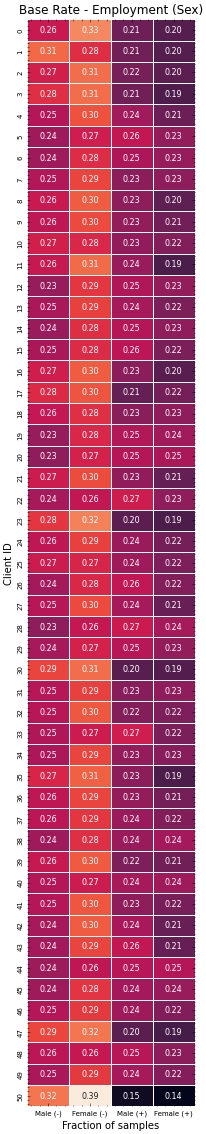

In [38]:

time_step = 199
hidden_shape_dict = {
        'income':32, 
        'health':64, 
        'employment':64}

task_name = {
    'income': 'Income',
    'health': 'Health',
    'employment': 'Employment'
}

task = 'employment'
res_dict = {}
for client_idx in range(51):
    res_dict[client_idx] = {}
for random_seed in [0,1,2,3,4]:
    folder_path = "../results/{}/run_{}".format(task,random_seed)
    data_file = "{}/data.pkl".format(folder_path)
    with open(data_file,'rb') as f:  # Python 3: open(..., 'rb')
        dataset = pickle.load(f)
    (num_user, users, train_data_num, test_data_num, train_data_global, test_data_global, val_data_global, \
                        train_data_local_num_dict, test_data_local_num_dict, train_data_local_dict, test_data_local_dict, val_data_local_dict, class_num, unselected_data_local_dict) = dataset 

    for client_idx in range(51):
        x,y,s = get_dataset(test_data_local_dict[client_idx])
        for attr_idx in [1]:
            converted_s = s[:,attr_idx] #gender
           
            for s_value in np.unique(converted_s):
                for label in [0,1]:
                    if f'{attr_idx}_{s_value}_{label}' not in res_dict[client_idx].keys():
                        res_dict[client_idx][f'{attr_idx}_{s_value}_{label}'] = []
                    index = np.logical_and(y==label,converted_s==s_value)
                    res_dict[client_idx][f'{attr_idx}_{s_value}_{label}'].append(np.sum(index))
                    
aggregate_res = {}
for key in res_dict[0].keys():
    aggregate_res[key] = np.array([np.mean(res_dict[client_idx][key]) for client_idx in range(51)])
f, ax = plt.subplots(figsize=(3, 20))



In [ ]:
total_num = aggregate_res['1_1_0']+ aggregate_res['1_2_0']+ aggregate_res['1_1_1']+ aggregate_res['1_2_1']
data = np.array([aggregate_res['1_1_0']/total_num,aggregate_res['1_2_0']/total_num,aggregate_res['1_1_1']/total_num,aggregate_res['1_2_1']/total_num])


sns.heatmap(data.T, cbar=False,\
            annot=True, fmt=".2f", linewidths=.5, ax=ax, annot_kws={'fontsize':8})
plt.ylabel('Client ID',fontsize=10)
plt.xlabel('Fraction of samples',fontsize=10)
plt.xticks(ticks=[0.5,1.5,2.5,3.5],labels=['Male (-)','Female (-)','Male (+)','Female (+)'])
plt.title('Base Rate - {} (Sex)'.format(task_name[task]))
pathlib.Path('{}/non-iid/'.format(task)).mkdir(parents=True, exist_ok=True) 
plt.savefig('{}/non-iid/subgroup_distribution_attr_{}.png'.format(task,1),dpi=300)

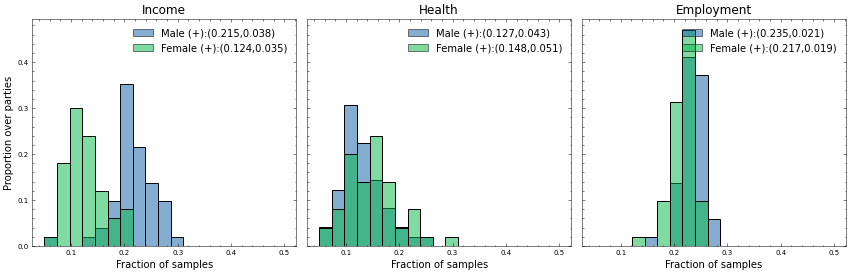

In [74]:



from matplotlib.patches import Patch
f,ax=plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)

for row_idx,task in enumerate(['income','health','employment']):
    res_dict = {}
    for client_idx in range(51):
        res_dict[client_idx] = {}
    for random_seed in [0,1,2,3,4]:
        folder_path = "../results/{}/run_{}".format(task,random_seed)
        data_file = "{}/data.pkl".format(folder_path)
        with open(data_file,'rb') as f:  # Python 3: open(..., 'rb')
            dataset = pickle.load(f)
        (num_user, users, train_data_num, test_data_num, train_data_global, test_data_global, val_data_global, \
                            train_data_local_num_dict, test_data_local_num_dict, train_data_local_dict, test_data_local_dict, val_data_local_dict, class_num, unselected_data_local_dict) = dataset 

        for client_idx in range(51):
            x,y,s = get_dataset(test_data_local_dict[client_idx])
            for attr_idx in [1]:
                converted_s = s[:,attr_idx] #gender
            
                for s_value in np.unique(converted_s):
                    for label in [0,1]:
                        if f'{attr_idx}_{s_value}_{label}' not in res_dict[client_idx].keys():
                            res_dict[client_idx][f'{attr_idx}_{s_value}_{label}'] = []
                        index = np.logical_and(y==label,converted_s==s_value)
                        res_dict[client_idx][f'{attr_idx}_{s_value}_{label}'].append(np.sum(index))
    aggregate_res = {}
    for key in res_dict[0].keys():
        aggregate_res[key] = np.array([np.mean(res_dict[client_idx][key]) for client_idx in range(51)])
        
    bins = np.linspace(0.05,0.5,20)
    labels=['Male (-)','Female (-)','Male (+)','Female (+)']

    # for idx,key in enumerate(['1_1_0','1_2_0']):#,'1_1_1','1_2_1']):
    sns.histplot(aggregate_res['1_1_1']/total_num,bins=bins,stat='probability',label=labels[idx],alpha=0.5,ax=ax[row_idx])
    mean_1=round(np.mean(aggregate_res['1_1_1']/total_num),3)
    std_1=round(np.std(aggregate_res['1_1_1']/total_num),3) 
    sns.histplot(aggregate_res['1_2_1']/total_num,bins=bins,stat='probability',label=labels[idx],alpha=0.5,ax=ax[row_idx])
    mean_2=round(np.mean(aggregate_res['1_2_1']/total_num),3)
    std_2=round(np.std(aggregate_res['1_2_1']/total_num),3) 

    legend_elements = [Patch(facecolor='C0', edgecolor='black',alpha=0.5,
                            label='{}:({},{})'.format(labels[2],mean_1,std_1)),
                    Patch(facecolor='C1', edgecolor='black',alpha=0.5,
                            label='{}:({},{})'.format(labels[3],mean_2,std_2))]
    
    ax[row_idx].set_ylabel('Proportion over parties',fontsize=10)
    ax[row_idx].legend(handles=legend_elements, loc='upper right',fontsize=10)
    ax[row_idx].set_xlabel('Fraction of samples',fontsize=10)
    ax[row_idx].set_title(task_name[task])
    
    
    # sns.histplot(aggregate_res['1_1_1']/total_num,bins=bins,stat='probability',label=labels[idx],alpha=0.5,ax=ax[1,row_idx])
    # mean_1=round(np.mean(aggregate_res['1_1_1']/total_num),3)
    # std_1=round(np.std(aggregate_res['1_1_1']/total_num),3) 
    # sns.histplot(aggregate_res['1_2_1']/total_num,bins=bins,stat='probability',label=labels[idx],alpha=0.5,ax=ax[1,row_idx])
    # mean_2=round(np.mean(aggregate_res['1_2_1']/total_num),3)
    # std_2=round(np.std(aggregate_res['1_2_1']/total_num),3) 

    # legend_elements = [Patch(facecolor='C0', edgecolor='black',alpha=0.5,
    #                         label='{}:({},{})'.format(labels[2],mean_1,std_1)),
    #                 Patch(facecolor='C1', edgecolor='black',alpha=0.5,
    #                         label='{}:({},{})'.format(labels[3],mean_2,std_2))]
    
    # ax[1,row_idx].set_ylabel('Proportion over parties',fontsize=10)
    # ax[1,row_idx].legend(handles=legend_elements, loc='upper right',fontsize=10)
    # ax[1,row_idx].set_xlabel('Fraction of samples',fontsize=10)
    # ax[1,row_idx].set_title(task_name[task])
    
   
    plt.tight_layout()
    
pathlib.Path('non-iid-combined/').mkdir(parents=True, exist_ok=True) 
plt.savefig('non-iid-combined/hist_base_rate_attr_{}_combined.png'.format(task,1),dpi=300)

In [72]:
np.stack([aggregate_res['1_1_0'],aggregate_res['1_2_0'],aggregate_res['1_1_1'],aggregate_res['1_2_1']]).shape

(4, 51)

# Effect of scaling other parameters

In [2]:
from analysis_plot import *


def get_random_baseline(random_index):
    time_step = 199
    random_seed_list = [0,1,2,3,4]
    all_results = {'acc':[],'eo':[],'dp':[],'weight':[],'client':[],'rs':[]}
    if os.path.isfile('income/csv/scaling_results_others_{}.csv'.format(random_index)):
        all_results_df = pd.read_csv('income/csv/scaling_results_others_{}.csv'.format(random_index))
    else:
        for random_seed in random_seed_list:
            folder_path = "../results/income/run_{}".format(random_seed)
            data_file = "{}/data.pkl".format(folder_path)
            with open(data_file,'rb') as f:  # Python 3: open(..., 'rb')
                dataset = pickle.load(f)


            (num_user, users, train_data_num, test_data_num, train_data_global, test_data_global, val_data_global, \
                        train_data_local_num_dict, test_data_local_num_dict, train_data_local_dict, test_data_local_dict, val_data_local_dict, class_num, unselected_data_local_dict) = dataset 
            test_model = TwoNN(54,32,2)
            for client_idx in range(51):
                x,y,s = get_dataset(test_data_local_dict[client_idx])
                weight =1 
                test_weight = copy.deepcopy(torch.load("{}/fedavg_at_{}.pt".format(folder_path,time_step)))
                test_weight['fc1.weight'][:,random_index:random_index+2] = weight*test_weight['fc1.weight'][:,random_index:random_index+2]
                test_model.load_state_dict(test_weight)
                acc,eo_gap,dp_gap,_ = get_performance(test_model,x,y,s,1)
                all_results['acc'].append(acc)
                all_results['eo'].append(eo_gap)
                all_results['dp'].append(dp_gap)
                all_results['weight'].append(weight)
                all_results['client'].append(client_idx)
                all_results['rs'].append(random_seed)

                for weight in np.logspace(-1,1,100):
                    test_weight = copy.deepcopy(torch.load("{}/fedavg_at_{}.pt".format(folder_path,time_step)))
                    test_weight['fc1.weight'][:,random_index:random_index+2] = weight*test_weight['fc1.weight'][:,random_index:random_index+2]
                    test_model.load_state_dict(test_weight)
                    acc,eo_gap,dp_gap,_ = get_performance(test_model,x,y,s,1)
                    all_results['acc'].append(acc)
                    all_results['eo'].append(eo_gap)
                    all_results['dp'].append(dp_gap)
                    all_results['weight'].append(weight)
                    all_results['client'].append(client_idx)
                    all_results['rs'].append(random_seed)

        all_results_df = pd.DataFrame.from_dict(all_results)
        all_results_df.to_csv('income/csv/scaling_results_others_{}.csv'.format(random_index))
    return all_results_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


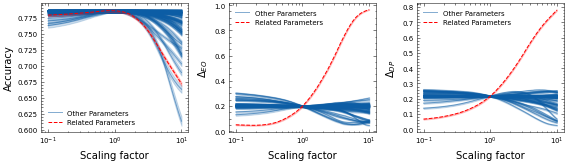

In [87]:
from analysis_plot import *
font_size=10
df_list = []
base_results_df = pd.read_csv('income/csv/scaling_results.csv')
base_results_df['para']  = 43
df_list.append(base_results_df)
# figs,axes = plt.subplots(1,2,figsize=(6,2))

fig, ax1 = plt.subplots(1,3,figsize=(8,2.4))

eo_color = rgb(217,95,2)
dp_color = rgb(117,112,179)
acc_color=rgb(116,173,209)

for i in range(54):
    print(i)
    
    if i not in [42,43,44]:
        all_results_df = get_random_baseline(i)
        all_results_df['para']  = i
        df_list.append(all_results_df)
    
    if i != 0:
        sns.lineplot(data=all_results_df,x='weight',y='eo',err_style="band", errorbar=("se", 2),color='C0',ax=ax1[1],alpha=0.5)
        sns.lineplot(data=all_results_df,x='weight',y='dp',err_style="band", errorbar=("se", 2),color='C0',ax=ax1[2],alpha=0.5)
        sns.lineplot(data=all_results_df,x='weight',y='acc',err_style="band", errorbar=("se", 2),color='C0',ax=ax1[0],alpha=0.5)
    else:
        sns.lineplot(data=all_results_df,x='weight',y='eo',err_style="band", errorbar=("se", 2),color='C0',ax=ax1[1],label='Other Parameters',alpha=0.5)
        sns.lineplot(data=all_results_df,x='weight',y='dp',err_style="band", errorbar=("se", 2),color='C0',ax=ax1[2],label='Other Parameters',alpha=0.5)
        sns.lineplot(data=all_results_df,x='weight',y='acc',err_style="band", errorbar=("se", 2),color='C0',ax=ax1[0],label='Other Parameters',alpha=0.5)


sns.lineplot(data=base_results_df,x='weight',y='eo',label='Related Parameters',err_style="band", errorbar=("se", 2),color='red',ax=ax1[1],linestyle='--')
sns.lineplot(data=base_results_df,x='weight',y='dp',label='Related Parameters',err_style="band", errorbar=("se", 2),color='red',ax=ax1[2],linestyle='--')
sns.lineplot(data=base_results_df,x='weight',y='acc',label='Related Parameters',err_style="band", errorbar=("se", 2),color='red',ax=ax1[0],linestyle='--')



ax1[0].set_xscale('log')
ax1[1].set_xscale('log')
ax1[2].set_xscale('log')

ax1[0].set_xlabel('Scaling factor',fontsize=font_size)
ax1[1].set_xlabel('Scaling factor',fontsize=font_size)
ax1[2].set_xlabel('Scaling factor',fontsize=font_size)


ax1[0].set_ylabel('Accuracy',fontsize=font_size)
ax1[1].set_ylabel(r'$\Delta_{EO}$',fontsize=font_size)
ax1[2].set_ylabel(r'$\Delta_{DP}$',fontsize=font_size)



plt.tight_layout()
plt.savefig('income/effect_parameters/effect_scaling_comparision_{}.png'.format(199),dpi=1000)


<Figure size 237.6x180 with 0 Axes>

In [74]:
all_df = pd.concat(df_list)

In [75]:
plot_data = all_df.groupby(['para','weight']).mean().reset_index()

In [88]:
# # norm = plt.Normalize(all_df['weight'].min(), all_df['weight'].max())
# # sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
# # sm.set_array([])


# f,axes = plt.subplots(1,2,figsize=(6,3),sharex=True)
# sns.scatterplot(data=plot_data[plot_data['para']!=43],x='acc',y='eo',color='C0', s=10,ax=axes[0],label='Other Parameters')
# sns.scatterplot(data=plot_data[plot_data['para']==43],x='acc',marker='^',y='eo',color='C1', s=10,ax=axes[0],label='Related Parameters')
# axes[0].set_xlabel('Accuracy')
# axes[0].set_ylabel(r'$\Delta_{EO}$')
# axes[0].legend()


# sns.scatterplot(data=plot_data[plot_data['para']!=43],x='acc',y='dp',ax=axes[1],color='C0', s=10,label='Other Parameters')
# sns.scatterplot(data=plot_data[plot_data['para']==43],x='acc',y='dp',ax=axes[1],color='C1', marker='^', s=10,label='Related Parameters')
# axes[1].set_xlabel('Accuracy')
# axes[1].set_ylabel(r'$\Delta_{DP}$')
# plt.tight_layout()


# plt.savefig('income/effect_parameters/effect_scaling_comparision_{}.png'.format(199),dpi=1000)


# Model parameter distribution across parties